# Variational Autoencoder with Clustering for Health Severity Analysis
This notebook implements a Variational Autoencoder (VAE) on structured health data to identify patient clusters corresponding to different levels of health severity. The steps include:
1. Setup and Configuration
2. Data Loading and Preprocessing
3. VAE Model Definition and Hyperparameter Tuning
4. Model Training and Reconstruction Error Calculation
5. Latent Space Extraction and Clustering
6. Latent Space Visualization
7. Health Severity Index Assignment
8. Cluster Analysis and Validation
9. Memory Management and Cleanup

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and deep learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras_tuner import BayesianOptimization


# Enable inline plotting
%matplotlib inline


In [5]:
# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable memory growth for GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPU")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. The code will run on CPU, which might be slower.")


Num GPUs Available:  1
Enabled memory growth on GPU


### 2. Data Loading and Preprocessing
We load the preprocessed structured data, standardize it, and split it into training and validation sets.

In [6]:
# Load preprocessed structured data
structured_data = pd.read_csv('structured_data_preprocessed.csv')

# Separate features
X_structured = structured_data.values.astype('float32')  # Use float32 for efficiency

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_structured)

# Save scaler for future use
joblib.dump(scaler, 'scaler.joblib')

# Train-test split
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Clear unnecessary variables
del X_structured
del X_scaled


### 3. VAE Model Definition and Hyperparameter Tuning
We define the VAE model and set up hyperparameter tuning using Keras Tuner's 
<code>BayesianOptimization</code>.

In [7]:
# # Sampling Layer
# class Sampling(layers.Layer):
#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.random.normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# # VAE Model
# class VAE(tf.keras.Model):
#     def __init__(self, encoder, decoder, input_dim, **kwargs):
#         super(VAE, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder
#         self.input_dim = input_dim

#     def call(self, inputs):
#         z_mean, z_log_var, z = self.encoder(inputs)
#         reconstructed = self.decoder(z)
        
#         reconstruction_loss = tf.reduce_mean(
#             tf.keras.losses.MeanSquaredError()(inputs, reconstructed)
#         ) * self.input_dim
        
#         # KL divergence loss
#         kl_loss = -0.5 * tf.reduce_mean(
#             1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
#         )
        
#         # Add the losses to the model
#         self.add_loss(reconstruction_loss)
#         self.add_loss(kl_loss)
        
#         return reconstructed


# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, input_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.MeanSquaredError()(inputs, reconstructed)
        ) * self.input_dim
        
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        
        # Add the losses to the model
        self.add_loss(reconstruction_loss)
        self.add_loss(kl_loss)
        
        return reconstructed

    def get_config(self):
        # Serialize encoder and decoder as part of the config
        config = super(VAE, self).get_config()
        config.update({
            'encoder': self.encoder.get_config(),
            'decoder': self.decoder.get_config(),
            'input_dim': self.input_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Rebuild encoder and decoder from their configs
        encoder_config = config.pop('encoder')
        decoder_config = config.pop('decoder')
        
        encoder = tf.keras.Model.from_config(encoder_config)
        decoder = tf.keras.Model.from_config(decoder_config)
        input_dim = config.pop('input_dim')
        
        return cls(encoder, decoder, input_dim, **config)


##### 3.1 Define the VAE Hypermodel

In [8]:
def build_vae(hp):
    input_dim = X_train.shape[1]
    
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    x = input_layer
    num_layers = hp.Int('num_layers', 1, 3)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    l2_reg = hp.Float('l2_reg', 1e-5, 1e-3, sampling='log')
    
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=64, max_value=256, step=64)
        x = layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        )(x)
    
    # Latent Space
    encoding_dim = hp.Int('encoding_dim', min_value=2, max_value=32, step=2)
    z_mean = layers.Dense(encoding_dim, name='z_mean')(x)
    z_log_var = layers.Dense(encoding_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    
    # Encoder Model
    encoder = tf.keras.Model(inputs=input_layer, outputs=[z_mean, z_log_var, z], name='encoder')
    
    # Decoder
    latent_inputs = layers.Input(shape=(encoding_dim,))
    x = latent_inputs
    for i in range(num_layers):
        units = hp.Int(f'units_dec_{i}', min_value=64, max_value=256, step=64)
        x = layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        )(x)
    
    outputs = layers.Dense(input_dim, activation='linear')(x)
    
    # Decoder Model
    decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')
    
    # VAE Model
    vae = VAE(encoder, decoder, input_dim=input_dim)
    
    # Compile the model
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
    return vae


##### 3.2 Set Up Hyperparameter Tuning

In [9]:
# Set up the tuner
tuner = BayesianOptimization(
    build_vae,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='vae_tuning',
    project_name='vitai_vae'
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


Reloading Tuner from vae_tuning\vitai_vae\tuner0.json


##### 3.3 Run Hyperparameter Search

In [10]:
# Run the hyperparameter search
tuner.search(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
)

### 4. Model Training and Reconstruction Error Calculation
After finding the best hyperparameters, we train the VAE model and compute the reconstruction error.

##### 4.1 Train the Best Model

In [11]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
print(f"""
The optimal number of layers is {best_hps.get('num_layers')} encoder and decoder layers.
The optimal number of units in each layer are:
Encoder units: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
Decoder units: {[best_hps.get(f'units_dec_{i}') for i in range(best_hps.get('num_layers'))]}
The optimal activation function is {best_hps.get('activation')}.
The optimal encoding dimension is {best_hps.get('encoding_dim')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
)

# Save the model in TensorFlow format (use .keras or .h5 extension)
best_model.save('vae_model.keras')  # Use .keras or .h5 for saving


# Clear session to free memory
keras.backend.clear_session()



The optimal number of layers is 2 encoder and decoder layers.
The optimal number of units in each layer are:
Encoder units: [256, 64]
Decoder units: [192, 256]
The optimal activation function is relu.
The optimal encoding dimension is 30.
The optimal learning rate is 0.0002519654858611606.

Epoch 1/50
1461/1461 [==============================] - 6s 3ms/step - loss: 23.1579 - val_loss: 11.1437
Epoch 2/50
1461/1461 [==============================] - 4s 3ms/step - loss: 9.6258 - val_loss: 8.3802
Epoch 3/50
1461/1461 [==============================] - 3s 2ms/step - loss: 7.7346 - val_loss: 6.9228
Epoch 4/50
1461/1461 [==============================] - 3s 2ms/step - loss: 6.9081 - val_loss: 6.4075
Epoch 5/50
1461/1461 [==============================] - 4s 2ms/step - loss: 6.1535 - val_loss: 5.8434
Epoch 6/50
1461/1461 [==============================] - 4s 2ms/step - loss: 5.7547 - val_loss: 5.6576
Epoch 7/50
1461/1461 [==============================] - 4s 2ms/step - loss: 5.5261 - val_loss

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

##### 4.2 Compute Reconstruction Error

In [9]:
# Load the best model
custom_objects = {'VAE': VAE, 'Sampling': Sampling}
best_model = tf.keras.models.load_model('vae_model.keras', custom_objects=custom_objects)

# Re-compile the model to include custom loss
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')))


# Compute reconstruction error for the entire training dataset
reconstructed = best_model.predict(X_train, batch_size=64)
reconstruction_errors = np.mean(np.square(X_train - reconstructed), axis=1)

# Add reconstruction error to the data
train_reconstruction_error = pd.DataFrame({'Reconstruction Error': reconstruction_errors})

# Save reconstruction errors
train_reconstruction_error.to_csv('train_reconstruction_error.csv', index=False)


1461/1461 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step


##### 4.3 Plot Reconstruction Error Distribution

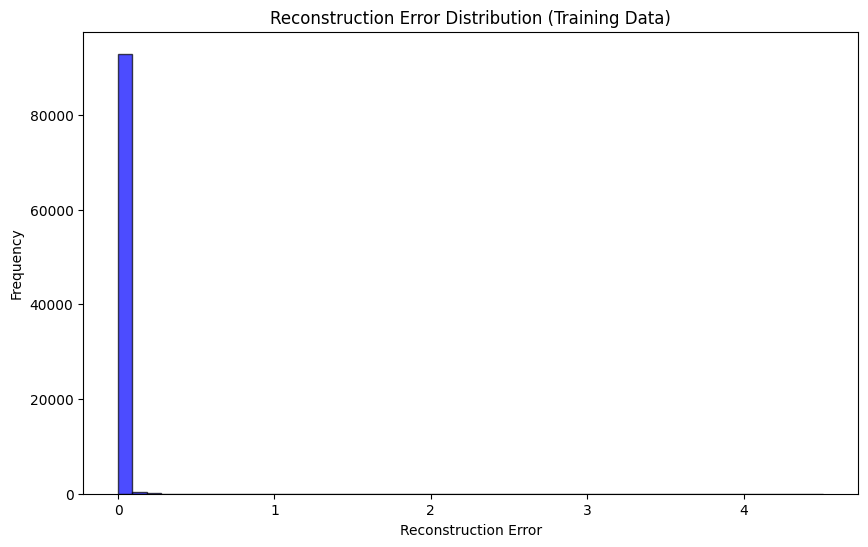

In [10]:
# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Reconstruction Error Distribution (Training Data)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

### 5. Latent Space Extraction and Clustering
We extract the latent features from the encoder and apply clustering algorithms to identify patient groups.

##### 5.1 Extract Latent Features

In [11]:
# 5.1 Extract Latent Features

# Use the encoder model directly from the best_model
encoder = best_model.encoder

# Obtain latent representation
z_mean, z_log_var, z = encoder.predict(X_train, batch_size=64)

# Use the sampled latent vector z for clustering
latent_features = z

# Create a DataFrame for latent features
latent_dim = best_hps.get('encoding_dim')
latent_features_df = pd.DataFrame(data=latent_features, columns=[f'latent_{i}' for i in range(latent_dim)])

# Add reconstruction error to the latent features DataFrame
latent_features_df['reconstruction_error'] = reconstruction_errors

# Save the latent features
latent_features_df.to_csv('latent_features.csv', index=False)
#


1461/1461 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step


##### 5.2 Clustering and Evaluation

In [ ]:
# Clustering algorithms to try
clustering_algorithms = {
    'KMeans': KMeans,
    'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering
}

# For KMeans and AgglomerativeClustering, test different numbers of clusters
range_n_clusters = list(range(2, 10))

best_algorithm = None
best_score = -1
best_labels = None
best_n_clusters = None

for name, algorithm in clustering_algorithms.items():
    print(f"\nTesting {name}...")
    if name == 'KMeans' or name == 'AgglomerativeClustering':
        for n_clusters in range_n_clusters:
            if name == 'KMeans':
                clustering = algorithm(n_clusters=n_clusters, random_state=42)
            else:
                clustering = algorithm(n_clusters=n_clusters)
            cluster_labels = clustering.fit_predict(latent_features)
            silhouette_avg = silhouette_score(latent_features, cluster_labels)
            print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_algorithm = name
                best_labels = cluster_labels
                best_n_clusters = n_clusters
    elif name == 'DBSCAN':
        # Try different eps and min_samples
        eps_values = [0.3, 0.5, 0.7]
        min_samples_values = [5, 10]
        for eps in eps_values:
            for min_samples in min_samples_values:
                clustering = algorithm(eps=eps, min_samples=min_samples)
                cluster_labels = clustering.fit_predict(latent_features)
                # For DBSCAN, some labels might be -1 (noise)
                # We need at least 2 clusters to compute silhouette score
                if len(set(cluster_labels)) > 1 and -1 not in set(cluster_labels):
                    silhouette_avg = silhouette_score(latent_features, cluster_labels)
                    print(f"For eps = {eps}, min_samples = {min_samples}, the average silhouette_score is : {silhouette_avg}")
                    if silhouette_avg > best_score:
                        best_score = silhouette_avg
                        best_algorithm = f"{name} (eps={eps}, min_samples={min_samples})"
                        best_labels = cluster_labels
                        best_n_clusters = len(set(cluster_labels))
    else:
        print(f"Algorithm {name} not implemented.")

print(f"\nBest algorithm: {best_algorithm} with {best_n_clusters} clusters and silhouette score of {best_score}")

# Add the best cluster labels to the DataFrame
latent_features_df['cluster'] = best_labels

# Save the updated latent features
latent_features_df.to_csv('latent_features_with_clusters.csv', index=False)



Testing KMeans...
For n_clusters = 2, the average silhouette_score is : 0.054483287036418915
For n_clusters = 3, the average silhouette_score is : 0.05288277193903923
For n_clusters = 4, the average silhouette_score is : 0.034134216606616974
For n_clusters = 5, the average silhouette_score is : 0.027851931750774384
For n_clusters = 6, the average silhouette_score is : 0.04369853064417839
For n_clusters = 7, the average silhouette_score is : 0.04213356226682663
For n_clusters = 8, the average silhouette_score is : 0.0467820018529892
For n_clusters = 9, the average silhouette_score is : 0.04406581073999405

Testing DBSCAN...

Testing AgglomerativeClustering...


### 6. Latent Space Visualization
We visualize the latent space using t-SNE and UMAP to understand the cluster formations.

##### 6.1 t-SNE Visualization

In [ ]:
# Use t-SNE for visualization
print("Performing t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_features)

# Add to DataFrame
latent_features_df['tsne_1'] = latent_2d[:, 0]
latent_features_df['tsne_2'] = latent_2d[:, 1]

# Plot t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=latent_features_df, palette='viridis', legend='full')
plt.title('Latent Space Visualization with t-SNE')
plt.show()


##### 6.2 UMAP Visualization

In [ ]:
# Use UMAP for visualization
try:
    import umap

    print("Performing UMAP...")
    reducer = umap.UMAP(random_state=42)
    latent_2d_umap = reducer.fit_transform(latent_features)

    # Add to DataFrame
    latent_features_df['umap_1'] = latent_2d_umap[:, 0]
    latent_features_df['umap_2'] = latent_2d_umap[:, 1]

    # Plot UMAP
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='umap_1', y='umap_2', hue='cluster', data=latent_features_df, palette='viridis', legend='full')
    plt.title('Latent Space Visualization with UMAP')
    plt.show()
except ImportError:
    print("UMAP is not installed. Skipping UMAP visualization.")


### 7. Health Severity Index Assignment
We assign a health severity index based on the cluster assignments.

In [ ]:
# Map clusters to severity scores
cluster_severity = {cluster: index for index, cluster in enumerate(sorted(latent_features_df['cluster'].unique()))}
latent_features_df['severity_index'] = latent_features_df['cluster'].map(cluster_severity)

# Optionally, scale severity index to 0-10 range
scaler_severity = MinMaxScaler(feature_range=(0, 10))
latent_features_df['severity_index_scaled'] = scaler_severity.fit_transform(latent_features_df[['severity_index']])


### 8. Cluster Analysis and Validation
We analyze the clusters to ensure they make clinical sense by examining the characteristics of each cluster.

##### 8.1 Combine Data for Analysis

In [ ]:
# Combine original data with cluster labels
analysis_df = pd.DataFrame(X_train, columns=structured_data.columns)
analysis_df['cluster'] = latent_features_df['cluster']
analysis_df['severity_index'] = latent_features_df['severity_index_scaled']
analysis_df['reconstruction_error'] = latent_features_df['reconstruction_error']


##### 8.2 Compute Summary Statistics

In [ ]:
# Group by cluster and compute summary statistics
cluster_summary = analysis_df.groupby('cluster').mean()
print("\nCluster Summary Statistics:")
print(cluster_summary)


##### 8.3 Visualize Reconstruction Error by Cluster

In [ ]:
# Visualize reconstruction error by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='reconstruction_error', data=analysis_df)
plt.title('Reconstruction Error by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Reconstruction Error')
plt.show()


##### 8.4 Visualize Key Features by Cluster

In [ ]:
# Visualize key features by cluster
key_features = structured_data.columns.tolist()  # List of feature names

# Limit to first 5 features for brevity
for feature in key_features[:5]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=analysis_df)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


### 9. Memory Management and Cleanup
We perform cleanup to manage memory efficiently.

In [ ]:
# Clear variables to free memory
del X_train
del X_val
del latent_features
del latent_2d
if 'latent_2d_umap' in locals():
    del latent_2d_umap
del encoder
del best_model

print("Analysis complete.")


## Conclusion
In this notebook, we successfully:
<ul>
<li>Implemented a Variational Autoencoder to learn latent representations of patient health data.</li>
<li>Tuned hyperparameters to find the optimal VAE configuration.</li>
<li>Calculated reconstruction errors to assess model performance.</li>
<li>Applied different clustering algorithms to the latent space to identify patient groups.</li>
<li>Visualized the latent space using t-SNE and UMAP.</li>
<li>Assigned a health severity index based on cluster assignments.</li>
<li>Analyzed clusters to interpret the severity levels.</li>
</ul>
<br>
This approach allows us to identify patterns in patient data that may correspond to varying levels of health severity, aiding in clinical decision-making and resource allocation.